In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

from lcs.metrics import population_metrics
from lcs.agents import EnvironmentAdapter
from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.strategies.action_selection2 import BestAction, EpsilonGreedy, ActionDelay, KnowledgeArray

from time import sleep
from copy import copy

import pandas as pd
from matplotlib import pyplot as plt

# Load environments
import gym
import gym_grid

# Load utils
from utils.corridor import print_cl, plot_performance
from utils.postprocessing import parse_experiments_results

%matplotlib inline

In [2]:
grid_size = 20  # 5/10/20/100

ENV_NAME = f'grid-{grid_size}-v0'

EXPERIMENTS = 2
EXPLORE_TRIALS = 50
EXPLOIT_TRIALS = 10

In [3]:
env = gym.make(ENV_NAME)

# visualization
env.reset()
env.render()


('16', '19')
 20 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  $ 
 19 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  X  _  _  _  _ 
 18 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 17 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 16 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 15 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 14 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 13 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 12 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 11 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 10 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  9 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  8 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  7 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  6 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  5 _  _  _  _  _  _  _  _

# Metrics

## Knowledge

In [4]:
def grid_transitions(grid_size):
    MAX_POS = grid_size
    LEFT, RIGHT, UP, DOWN = 0, 1, 2, 3
    
    def _handle_state(state):
        moves = []
        (x, y) = state

        # handle inner rectangle - 4 actions available
        if 1 < x < MAX_POS and 1 < y < MAX_POS:
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        # handle bounds (except corners) - 3 actions available
        if x == 1 and y not in [1, MAX_POS]:  # left bound
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x == MAX_POS and y not in [1, MAX_POS]:  # right bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x not in [1, MAX_POS] and y == 1:  # lower bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

        if x not in [1, MAX_POS] and y == MAX_POS:  # upper bound
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        # handle corners - 2 actions available
        if x == 1 and y == 1:  # left-down
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

        if x == 1 and y == MAX_POS:  # left-up
            moves.append(((x, y), RIGHT, (x + 1, y)))
            moves.append(((x, y), DOWN, (x, y - 1)))

        if x == MAX_POS and y == 1:  # right-down
            moves.append(((x, y), LEFT, (x - 1, y)))
            moves.append(((x, y), UP, (x, y + 1)))

#         if x == 5 and y == 5:  # right-up (also reward)
#             moves.append(((x, y), LEFT, (x - 1, y)))
#             moves.append(((x, y), DOWN, (x, y - 1)))

        return moves
    
    transitions = []
    for x in range(1, MAX_POS+1):
        for y in range(1, MAX_POS+1):
            transitions += _handle_state((x, y))
    
    return transitions

transitions = grid_transitions(grid_size)

In [5]:
def calculate_knowledge(population, environment):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions) * 100.0

In [6]:
# exploit all possible state and check the action suggested
# if it's RIGHT or UP then it's optimal
def optimal_action_prob(population, environment):
    m = {}
    for state, _, _ in transitions:
        m[state]

# Experiments

In [7]:
# Build agent configuration
# Collect additional population metrics
def grid_metrics(pop, env):
    metrics = {
        'knowledge': calculate_knowledge(pop, env)
    }
    metrics.update(population_metrics(pop, env))
    return metrics

class GridAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return phenotype,

In [8]:
base_params = {
    "action_selector": EpsilonGreedy,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 2,
    "metrics_trial_frequency": 2,
#     "environment_adapter": GridAdapter,
    "user_metrics_collector_fcn": grid_metrics
}

In [9]:
def start_single_experiment(**kwargs):
    # Prepare the environment
    env.reset()

    cfg = Configuration(2, 4, **kwargs)
    sleep(1)
    
    explorer = ACS2(cfg)
    population_explore, metrics_explore = explorer.explore(env, EXPLORE_TRIALS)
    
    exploiter = ACS2(cfg, population_explore)
    population_exploit, metrics_exploit = explorer.exploit(env, EXPLOIT_TRIALS)
    
    # Parse results into DataFrame
    df = parse_experiments_results(metrics_explore, metrics_exploit, cfg.metrics_trial_frequency)
    
    return population_exploit, df

In [10]:
def avg_experiments(n, **kwargs):
    dfs = []
    print(f"{kwargs}\n")

    for i in range(n):
        print(f"Executing experiment {i}")
        pop, df = start_single_experiment(**kwargs)
        dfs.append(df)
    
    bar = pd.concat(dfs)
    perf_df = bar.groupby(['trial', 'phase']).mean().reset_index(level='phase')

    return perf_df

## Baseline (epsilon greedy)

In [11]:
# Prepare parameters
epsilon_greedy_params = copy(base_params)

epsilon_greedy_df = avg_experiments(EXPERIMENTS, **epsilon_greedy_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 2, 'metrics_trial_frequency': 2, 'user_metrics_collector_fcn': <function grid_metrics at 0x111a3a200>}

Executing experiment 0
Executing experiment 1


## Action Delay Bias

In [12]:
action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(EXPERIMENTS, **action_delay_params)

{'action_selector': <class 'lcs.strategies.action_selection2.ActionDelay.ActionDelay'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 2, 'metrics_trial_frequency': 2, 'user_metrics_collector_fcn': <function grid_metrics at 0x111a3a200>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1


## Knowledge Array Bias

In [13]:
knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(EXPERIMENTS, **knowledge_array_params)

{'action_selector': <class 'lcs.strategies.action_selection2.KnowledgeArray.KnowledgeArray'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 2, 'metrics_trial_frequency': 2, 'user_metrics_collector_fcn': <function grid_metrics at 0x111a3a200>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1


## Optimistic initial quality values

In [14]:
op_initial_params = copy(base_params)
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(EXPERIMENTS, **op_initial_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 2, 'metrics_trial_frequency': 2, 'user_metrics_collector_fcn': <function grid_metrics at 0x111a3a200>}

Executing experiment 0
Executing experiment 1


# Visualization

## Knowledge (latent-learning)

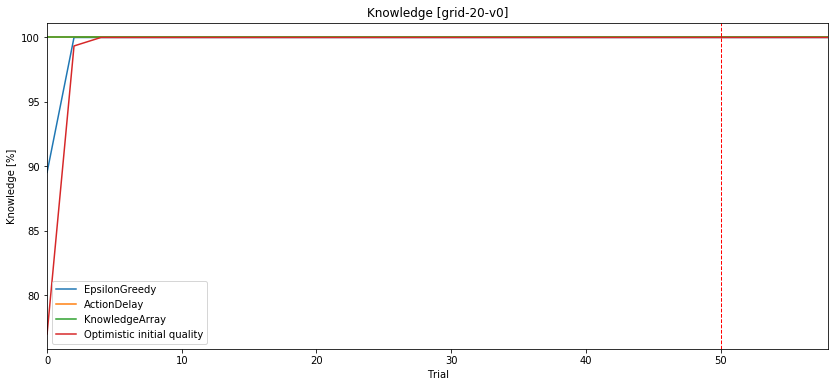

In [15]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['knowledge'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['knowledge'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['knowledge'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['knowledge'].plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Knowledge [%]')
ax.set_title(f'Knowledge [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()

## Steps to goal (reinforcement-learning)

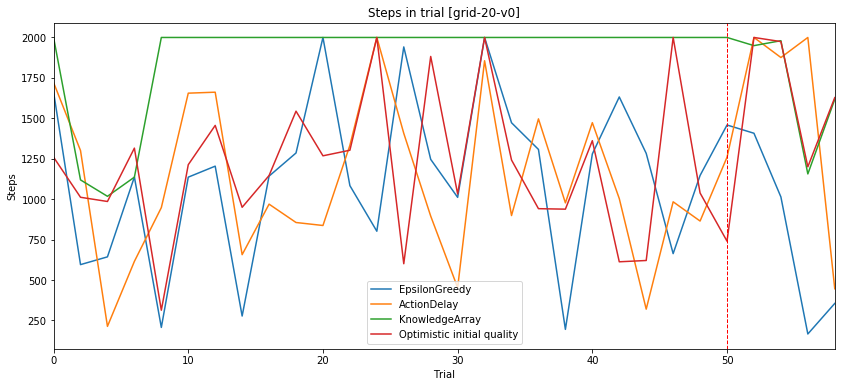

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['steps_in_trial'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['steps_in_trial'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['steps_in_trial'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['steps_in_trial'].plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Steps')
ax.set_title(f'Steps in trial [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()

## Population count

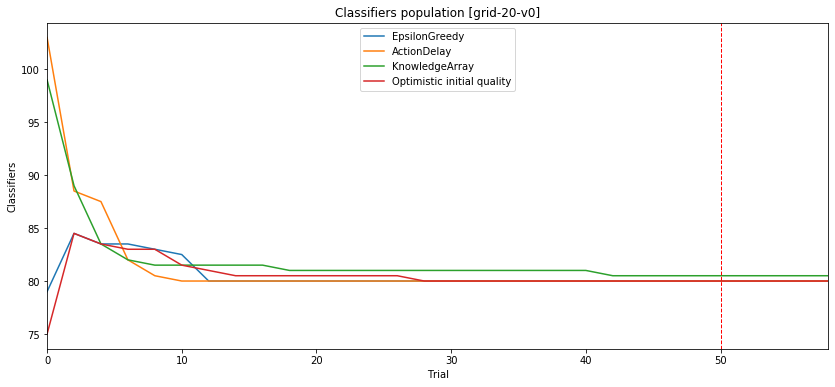

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['population'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['population'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['population'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['population'].plot(label='Optimistic initial quality', ax=ax)


ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')
ax.set_title(f'Classifiers population [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()